# Lecture 8: Split/Apply/Combine

# The Split/Apply/Combine Model

### Summary: Iterating in R without for()

* Subsetting by indexing with conditionals

* apply(): apply a function to rows or columns of a matrix or dataframe

* lapply(), sapply(): apply a function to elements of a list or vector

* cbind(), rbind(): concatenate these objects in a known pattern

## General Strategy: Split/Apply/Combine
### Key：Split-Apply-Combine

• Split whatever data object we have into meaningful chunks

• Apply the function of interest to each element in this division

• Combine the results into a new object of the desired structure

These are conceptual steps, often the apply and combine steps can be performed for us by a single call to the appropriate function from the apply() family.

Split-Apply-Combine听上去简单，但它在处理某些数据结构上非常有用。首先，比起for循环，它所需的代码量少；其次，比起“需求是什么”，我们现在思考“如何实现需求”；最后，并且在处理极大的数据集时，使我们正确地使用MapReduce/Hadoop。

# Example: Strikes dataset

Data set on 18 countries over 35 years compiled by Bruce Western, in the Sociology Department at Harvard University (now at Columbia University).

The measured variables:
* country, year: country and year of data collection
* strike.volume: days on strike per 1000 workers
* unemployment: unemployment rate
* inflation: inflation rate
* left.parliament: leftwing share of the goverment
* centralization: centralization of unions
* density: density of unions

In [1]:
# as.is控制character变量到factor的转换（目前它还没有被转换为logical，numeric或者complex）。as.is的取值为
# 由logicals组成的vector（必要时可以对值重复使用），或者一个由numeric或character indices组成的vector来确定
# 哪些列不需要被转换为factors。默认值为as.is = !stringsAsFactors。

# 简言之，as.is为FALSE时，自动把character转换为其它的数据类型（例如logical，numeric或complex），为TRUE时，
# 保留其数据结构。

strikes <- read.csv("strikes.csv", as.is = TRUE)
dim(strikes)

[1] 625   8

In [2]:
head(strikes)

country,year,strike.volume,unemployment,inflation,left.parliament,centralization,density
Australia,1951,296,1.3,19.8,43.0,0.3748588,NA
Australia,1952,397,2.2,17.2,43.0,0.3751829,NA
Australia,1953,360,2.5,4.3,43.0,0.3745076,NA
Australia,1954,3,1.7,0.7,47.0,0.3710170,NA
Australia,1955,326,1.4,2.0,38.5,0.3752675,NA
Australia,1956,352,1.8,6.3,38.5,0.3716072,NA


## Research Question

国家执政党（左翼 vs 右翼）和游行规模之间是否存在关系?

方法：
* 下策：分别手写18个代码块。
* 中策：使用for循环遍历country。
* 上策：分而治之，使用sapply()。

In [3]:
# Let's Study Just a Single Country
# subset(x, subset, select, drop = FALSE, ...)
italy.strikes <- subset(strikes, country == "Italy")

# Equivalently
italy.strikes <- strikes[strikes$country == "Italy", ]
dim(italy.strikes)

[1] 35  8

In [4]:
head(italy.strikes)

,country,year,strike.volume,unemployment,inflation,left.parliament,centralization,density
311,Italy,1951,437,8.8,14.3,37.5,0.2513799,NA
312,Italy,1952,337,9.5,1.9,37.5,0.2489860,NA
313,Italy,1953,545,10.0,1.4,40.2,0.2482739,NA
314,Italy,1954,493,8.7,2.4,40.2,0.2466577,NA
315,Italy,1955,511,7.5,2.3,40.2,0.2540366,NA
316,Italy,1956,372,9.3,3.4,40.2,0.2457069,NA


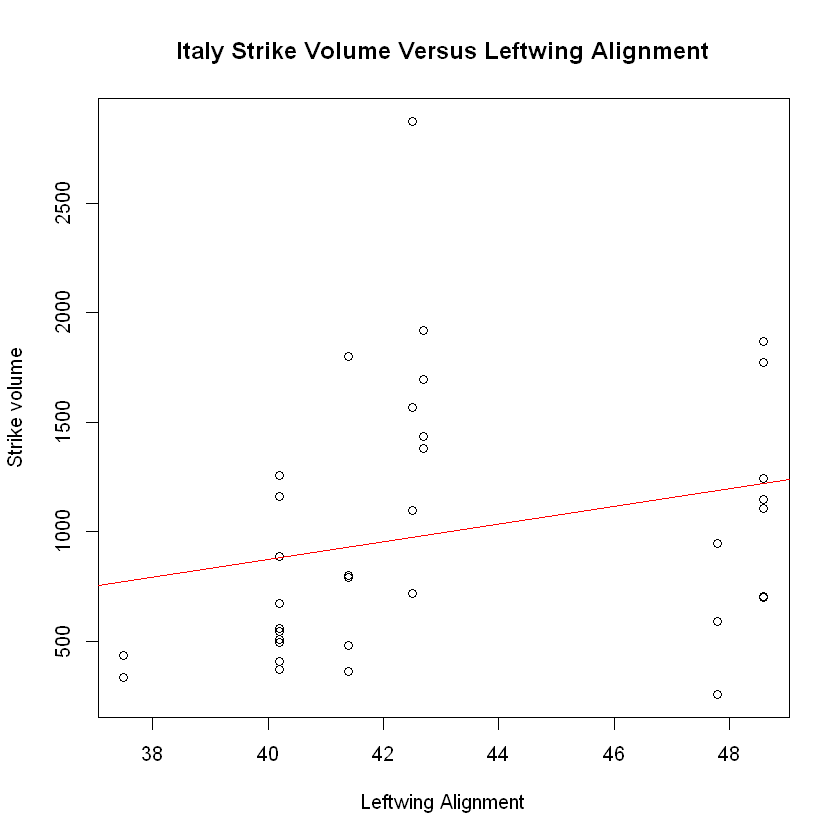

In [5]:
italy.fit <- lm(strike.volume ~ left.parliament, data = italy.strikes)
plot(strike.volume~left.parliament, data = italy.strikes, 
     main="Italy Strike Volume Versus Leftwing Alignment",ylab = "Strike volume",
     xlab = "Leftwing Alignment")
abline(italy.fit, col = 2)

### One Down, Seventeen To Go
重复进行如此操作枯燥且容易出错，如果使用更简单的方法？

In [6]:
# Now let’s generalize our functions. We want the linear model coefficients:
my.strike.lm <- function(country.df){
    return(lm(strike.volume~left.parliament, data = country.df)$coeff)
}
my.strike.lm(subset(strikes, country == "Italy"))

(Intercept) left.parliament 
     -738.74531        40.29109

In [7]:
# We could for() loop it...
strike.coef <- NULL
my.countries <- c("France", "Italy", "USA")

for(this.country in my.countries){
    country.dat <- subset(strikes, country == this.country)
    new.coefs <- my.strike.lm(country.dat)
    strike.coef <- cbind(strike.coef, new.coefs)
}
colnames(strike.coef) <- my.countries
strike.coef

,France,Italy,USA
(Intercept),202.4261408,-738.74531,111.440651
left.parliament,-0.4255319,40.29109,5.918647


## The Best Way

Steps:
1. 对数据进行分割，每一个数据子集都能适用于我们的函数。split(df, f = my.factor)函数将一个dataframe df根据factor my.factor定义的constant levels进行分割。

2. 对每一个数据子集进行apply我们的函数，经常使用lapply()函数或sapply()函数。

3. 把结果连接起来

In [8]:
# First we subset for every country using split().
strikes.split <- split(strikes, strikes$country)
names(strikes.split)
strikes.split[1]

[1] "Australia"   "Austria"     "Belgium"     "Canada"      "Denmark"    
 [6] "Finland"     "France"      "Germany"     "Ireland"     "Italy"      
[11] "Japan"       "Netherlands" "New.Zealand" "Norway"      "Sweden"     
[16] "Switzerland" "UK"          "USA"

country,year,strike.volume,unemployment,inflation,left.parliament,centralization,density
Australia,1951,296,1.3,19.8,43.0,0.3748588,NA
Australia,1952,397,2.2,17.2,43.0,0.3751829,NA
Australia,1953,360,2.5,4.3,43.0,0.3745076,NA
Australia,1954,3,1.7,0.7,47.0,0.3710170,NA
Australia,1955,326,1.4,2.0,38.5,0.3752675,NA
Australia,1956,352,1.8,6.3,38.5,0.3716072,NA
Australia,1957,195,2.3,2.5,38.5,0.3718757,NA
Australia,1958,133,2.7,1.3,36.9,0.3755677,NA
Australia,1959,109,2.6,1.8,36.9,0.3741668,NA
Australia,1960,208,2.5,3.8,36.9,0.3751240,50.2


现在我们希望将my.strikes.lm()函数apply在strike.split中每一个dataframe上。由于我们的函数返回一个长度为2的vector（截距和斜率），因此使用sapply()从而返回vector。

In [9]:
strike.coef <- sapply(strikes.split[1:12], my.strike.lm)
strike.coef

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Netherlands
(Intercept),414.7712254,423.077279,-56.926780,-227.8218,-1399.35735,108.2245,202.4261408,95.657134,-94.78661,-738.74531,964.73750,-32.627678
left.parliament,-0.8638052,-8.210886,8.447463,17.6766,34.34477,12.8422,-0.4255319,-1.312305,55.46721,40.29109,-24.07595,1.694387


We don’t care about the intercepts, only the slopes (2nd row), let’s plot them:

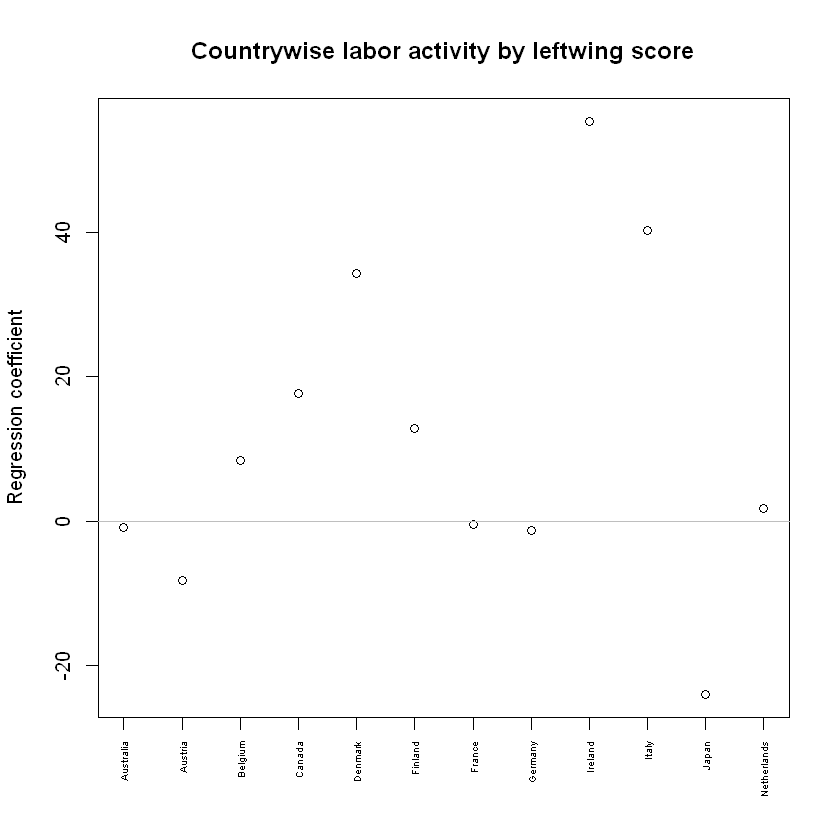

In [10]:
plot(1:ncol(strike.coef), strike.coef[2, ], xaxt="n", xlab="",
     ylab="Regression coefficient", main="Countrywise labor activity by leftwing score")
axis(side = 1, at = 1:ncol(strike.coef), labels = colnames(strike.coef),
     las = 2, cex.axis = 0.5)
abline(h = 0, col = "grey")

## Tasks
• Using split() and sapply(), compute the average unemployment rate, inflation rates, and strike volume for each year in the strikes data set. The output should be a matrix of dimension 3 $\times$ 35.

• Display the average unemployment rate by year and the average inflation rate by year, in the same plot. Label the axes and title the plot appropriately. Include an informative legend.

In [11]:
year_split <- split(strikes, strikes$year)
averages <- function(df){
    return(c(mean(df$unemployment), mean(df$inflation),
                  mean(df$strike.volume)))
}

year_data <- sapply(year_split, averages)
rownames(year_data) <- c("unemployment", "inflation", "volume")
year_data

,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985
unemployment,3.088889,3.683333,3.594444,3.505556,3.044444,3.033333,3.055556,3.422222,3.094444,2.555556,...,4.322222,4.605556,4.883333,4.577778,4.716667,5.647059,6.805882,7.823529,7.582353,7.323529
inflation,13.088889,5.794444,1.333333,1.833333,1.294444,3.705556,3.255556,3.472222,1.377778,1.955556,...,10.466667,9.733333,7.194444,8.250000,11.494444,11.405882,9.594118,6.629412,5.582353,5.464706
volume,359.222222,588.666667,211.944444,139.333333,215.277778,561.944444,216.111111,145.611111,239.444444,123.111111,...,411.555556,304.888889,257.833333,435.055556,367.277778,261.647059,227.882353,195.470588,274.176471,217.764706


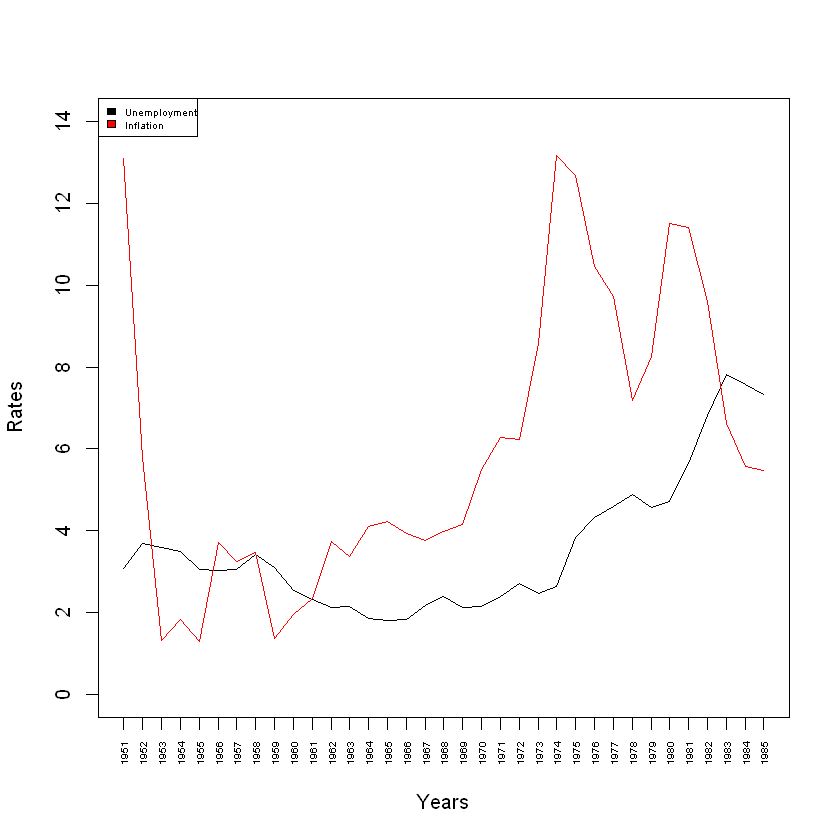

In [12]:
plot(1:ncol(year_data), year_data[1,], col = 1, type = "l", xlab = "Years", 
     xaxt="n", ylab = "Rates", ylim = c(0,14))
points(1:ncol(year_data), year_data[2,], col = 2, type = "l")
axis(side = 1, at = 1:ncol(year_data), labels = colnames(year_data),
     las = 2, cex.axis = 0.5)
legend("topleft", c("Unemployment", "Inflation"), fill = c("black", "red"), cex = .5)

# Using plyr

**Reminder: iterating in R without for()**

We've learned some tools in R for iteration without explicit for() loops:
* Indexing with conditionals + vectorization
* apply(): apply a function to rows or columns of a matrix or dataframe
* lapply(): apply a function to elements of a list or vector
* sapply(): same as the above, but simplify the output (if possible)
* tapply(): apply a function to levels of a factor vector

## The plyr package

The apply() family is often useful, but it has some issues: **primarily**, **inconsistent output**.

**plyr** Provides us with an extremely useful family of apply-like functions. Advantage over the built-in apply() family is its consistency.

All plyr functions are of the form `**ply()`. Replace ** with characters denoting types:

* First character: input type, one of a, d, l
* Second character: output type, one of a, d, l, or _ (drop)

\* a, d, l分别表示array, dataframe, list


## The signature for all a*ply() functions is: 
`a*ply(.data, .margins, .fun, ...)`
* .data : an array
* .margins : index (or indices) to split the array by
* .fun : the function to be applied to each piece
* ... : additional arguments to be passed to the function

\* 注意到这很像apply(x, margin, fun, ...)

## a*ply() Examples

In [13]:
my.array <- array(1:27, c(3,3,3))
rownames(my.array) <- c("R1", "R2", "R3")
colnames(my.array) <- c("C1", "C2", "C3")
dimnames(my.array)[[3]] <- c("Bart", "Lisa", "Maggie")

In [14]:
print(my.array)

, , Bart

   C1 C2 C3
R1  1  4  7
R2  2  5  8
R3  3  6  9

, , Lisa

   C1 C2 C3
R1 10 13 16
R2 11 14 17
R3 12 15 18

, , Maggie

   C1 C2 C3
R1 19 22 25
R2 20 23 26
R3 21 24 27



In [15]:
library("plyr")
# 分别在行(R)上求和
print(aaply(my.array, 1, sum)) # Get back an array
"_____________________________________________________"
print(adply(my.array, 1, sum)) # Get back a data frame
"_____________________________________________________"
print(alply(my.array, 1, sum)) # Get back a list

Warning message:
"package 'plyr' was built under R version 3.6.3"

 R1  R2  R3 
117 126 135 


[1] "_____________________________________________________"

  X1  V1
1 R1 117
2 R2 126
3 R3 135


[1] "_____________________________________________________"

$`1`
[1] 117

$`2`
[1] 126

$`3`
[1] 135

attr(,"split_type")
[1] "array"
attr(,"split_labels")
  X1
1 R1
2 R2
3 R3


In [16]:
# 分别在列与人名上求和
aaply(my.array, 2:3, sum) # Get back a 3 x 3 array

,Bart,Lisa,Maggie
C1,6,33,60
C2,15,42,69
C3,24,51,78


注意，在这个例子中，margin的1，2，3分别指R、C、人名，即行、列、表。这很容易记混，尤其是遇到更高维的数据时。因此遇到高维（>= 3维）数据时，应该记第几维，而不是行、列、...。在上一个例子中，2：3代表对第二与第三维度求和，则结果以这两个维度表出，所以结果是一个二维array。

In [17]:
adply(my.array, 2:3, sum) # Get back a data frame

X1,X2,V1
C1,Bart,6
C2,Bart,15
C3,Bart,24
C1,Lisa,33
C2,Lisa,42
C3,Lisa,51
C1,Maggie,60
C2,Maggie,69
C3,Maggie,78


In [18]:
alply(my.array, 2:3, sum) # Get back a list

$`1`
[1] 6

$`2`
[1] 15

$`3`
[1] 24

$`4`
[1] 33

$`5`
[1] 42

$`6`
[1] 51

$`7`
[1] 60

$`8`
[1] 69

$`9`
[1] 78

attr(,"split_type")
[1] "array"
attr(,"split_labels")
  X1     X2
1 C1   Bart
2 C2   Bart
3 C3   Bart
4 C1   Lisa
5 C2   Lisa
6 C3   Lisa
7 C1 Maggie
8 C2 Maggie
9 C3 Maggie

# l*ply() : The Input is a List

## The signature for all l*ply() functions is:
`l*ply(.data, .fun, ...)`

* .data : a list
* .fun : the function to be applied to each element
* ... : additional arguments to be passed to the function

\* 注意到这很像lapply(x, fun, ...)

## l*aply() Examples

In [19]:
my.list <- list(nums = rnorm(1000), lets = letters, pops = state.x77[ ,"Population"])
head(my.list[[1]], 5)
head(my.list[[3]], 5)

[1] -0.8485404  0.4878478 -1.4972144 -0.7079355 -0.7054749

Alabama     Alaska    Arizona   Arkansas California 
      3615        365       2212       2110      21198

In [20]:
laply(my.list, range) # Get back an array

1,2
-3.16484153261028,2.99983391838582
a,z
365,21198


In [21]:
ldply(my.list, range) # Get back a dataframe

.id,V1,V2
nums,-3.16484153261028,2.99983391838582
lets,a,z
pops,365,21198


In [22]:
llply(my.list, range) # Get back a list

$nums
[1] -3.164842  2.999834

$lets
[1] "a" "z"

$pops
[1]   365 21198

In [23]:
# Doesn't work! Outputs have different types/lengths
# laply(my.list, summary)
# ldply(my.list, summary)
llply(my.list, summary) # Works just fine

$nums
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.16484 -0.70379 -0.06255 -0.02616  0.67762  2.99983 

$lets
   Length     Class      Mode 
       26 character character 

$pops
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    365    1080    2838    4246    4968   21198 


## The Fourth Option for *
如果将输出选项*设置为_，即函数a_ply()或l_ply()，不会返回明确的object，但还是会在给定的array或list上遍历函数，可能会造成其它影响。

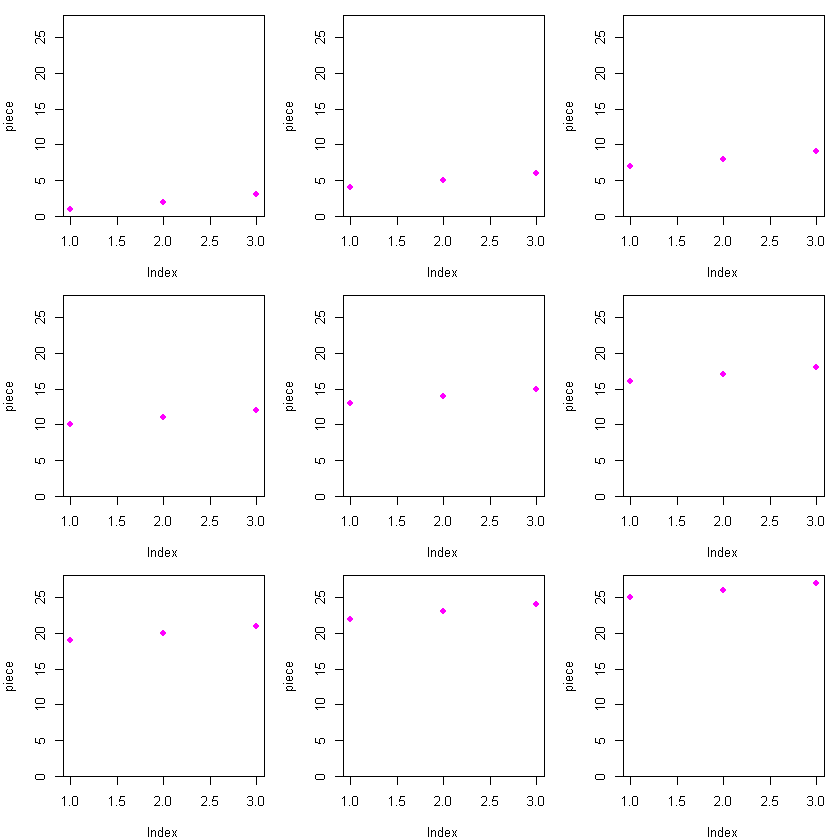

In [24]:
par(mfrow = c(3, 3), mar = c(4, 4, 1, 1))
a_ply(my.array, 2:3, plot, ylim = range(my.array), pch = 19, col = 6)

# d*ply() : The Input is a Data Frame
## The signature for all d*ply() functions is:
`d*ply(.data, .variables, .fun, ...)`
* .data : a data frame
* .variables : variable (or variables) to split the data frame by
* ."fun : the function to be applied to each piece
* ... : additional arguments to be passed to the function

\* 注意到这很像tapply(x, index, fun, ...), which applys a function to levels of a factor vector.

In [25]:
# Recall, data set on political economy of strikes and the function to 
# compute coefficients from regressing number of strikes (per 1000 workers)
# on leftwing share of the government:

my.strike.lm <- function(country.df){
    return(coef(lm(strike.volume~left.parliament, data=country.df)))
}

In [26]:
# 对于每个国家分别计算回归参数（老方法）：

strikes.list <- split(strikes, f = strikes$country)
strikes.coefs <- sapply(strikes.list, my.strike.lm)
strikes.coefs[, 1:12]

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Netherlands
(Intercept),414.7712254,423.077279,-56.926780,-227.8218,-1399.35735,108.2245,202.4261408,95.657134,-94.78661,-738.74531,964.73750,-32.627678
left.parliament,-0.8638052,-8.210886,8.447463,17.6766,34.34477,12.8422,-0.4255319,-1.312305,55.46721,40.29109,-24.07595,1.694387


In [27]:
# 对于每个国家分别计算回归参数（新方法，且返回三个不同数据结构的结果）：
strike.coef.a <- daply(strikes, .(country), my.strike.lm) # returns an array
head(strike.coef.a)

strike.coef.d <- ddply(strikes, .(country), my.strike.lm) # returns a dataframe
head(strike.coef.d)

strike.coef.l <- dlply(strikes, .(country), my.strike.lm) # returns a list
head(strike.coef.l)

,(Intercept),left.parliament
Australia,414.77123,-0.8638052
Austria,423.07728,-8.2108864
Belgium,-56.92678,8.4474627
Canada,-227.82177,17.6766029
Denmark,-1399.35735,34.3447662
Finland,108.22451,12.8422018


country,(Intercept),left.parliament
Australia,414.77123,-0.8638052
Austria,423.07728,-8.2108864
Belgium,-56.92678,8.4474627
Canada,-227.82177,17.6766029
Denmark,-1399.35735,34.3447662
Finland,108.22451,12.8422018


$Australia
    (Intercept) left.parliament 
    414.7712254      -0.8638052 

$Austria
    (Intercept) left.parliament 
     423.077279       -8.210886 

$Belgium
    (Intercept) left.parliament 
     -56.926780        8.447463 

$Canada
    (Intercept) left.parliament 
      -227.8218         17.6766 

$Denmark
    (Intercept) left.parliament 
    -1399.35735        34.34477 

$Finland
    (Intercept) left.parliament 
       108.2245         12.8422

## Splitting on Two or More Variables
The function d*ply() makes it very easy to split on two (or more) variables: we just specify them, separated by a “,” in the .variables argument.

In [28]:
# First create a variable that indicates whether the year is pre 1975,
# and add it to the data frame.

strikes$yearPre1975 <- strikes$year <= 1975
head(strikes)

country,year,strike.volume,unemployment,inflation,left.parliament,centralization,density,yearPre1975
Australia,1951,296,1.3,19.8,43.0,0.3748588,NA,TRUE
Australia,1952,397,2.2,17.2,43.0,0.3751829,NA,TRUE
Australia,1953,360,2.5,4.3,43.0,0.3745076,NA,TRUE
Australia,1954,3,1.7,0.7,47.0,0.3710170,NA,TRUE
Australia,1955,326,1.4,2.0,38.5,0.3752675,NA,TRUE
Australia,1956,352,1.8,6.3,38.5,0.3716072,NA,TRUE


In [29]:
# Then use (say) ddply() to compute regression coefficients 
# for each country pre & post 1975

strike.coef.75 <- ddply(strikes, .(country, yearPre1975), my.strike.lm)
head(strike.coef.75)
dim(strike.coef.75) # Note there are 18 x 2 = 36 rows

country,yearPre1975,(Intercept),left.parliament
Australia,FALSE,973.34088,-11.8094991
Australia,TRUE,-169.59900,12.0170866
Austria,FALSE,19.51823,-0.3470889
Austria,TRUE,400.83004,-7.7051918
Belgium,FALSE,-4182.06650,148.0049261
Belgium,TRUE,-103.67439,9.5802824


[1] 36  4

In [30]:
# 可以通过I()函数创建即时的factor variables.

strike.coef.75 <- ddply(strikes, .(country, I(year<=1975)), my.strike.lm)
head(strike.coef.75)
dim(strike.coef.75) # Again, 18 x 2 = 36 rows

country,I(year <= 1975),(Intercept),left.parliament
Australia,FALSE,973.34088,-11.8094991
Australia,TRUE,-169.59900,12.0170866
Austria,FALSE,19.51823,-0.3470889
Austria,TRUE,400.83004,-7.7051918
Belgium,FALSE,-4182.06650,148.0049261
Belgium,TRUE,-103.67439,9.5802824


[1] 36  4

# Parallelization

* 假设我们有一个极大的数据集，如何使用Split-Apply-Combine方法？


* 如果单个任务之间不相关，那么可以通过并行运算(perform in parallel)来加快计算速度。


* plyr函数使并行运算变得简单：观察daply()的结构：

`daply(.data, .variables, .fun = NULL, ..., .progress = "none", .inform = FALSE, .drop_i = TRUE, .drop_o = TRUE, .parallel = FALSE, .paropts = NULL)`
* 倒数第二项.parallel(默认为FALSE)是为了并行运算而设置。如果将它设置为TRUE，那么程序将会使用foreach package进行独立的任务的并行运算。

    * 区别：
    
    `daply(strikes.df, .(country), my.strike.lm)`
    
    `daply(strikes.df, .(country), my.strike.lm, .parallel = TRUE)`


* 最后一项.paropts是为了更高级的并行运算而设置，需要向foreach中传递更多的参数。想了解更多内容需要参考foreach package，需要时间来设置并行后端(backend)。而一旦设置完毕，用\**ply执行并行运算将变得简单且优雅。

## Tasks
* Compute the average inflation rate for each country pre and post 1975, from strikes, using a single call to daply(), i.e., without using any auxiliary columns in strikes, like the ones created in yearPre1975, countryPre1975. (Hint: Recall the function I(). You'll also have to write a quick function to get the inflation mean.)


* Do the same thing with split() and sapply() to check your results.

In [31]:
get_inflation_mean <- function(df){
    return(mean(df$inflation))
}
average_inflation <- daply(strikes, .(country, year <= 1975), get_inflation_mean)
average_inflation


# split() and sapply() approach:
strikes$isbefore1975 <- factor(strikes$year <= 1975)
strikes_split1 <- split(strikes, list(strikes$country, strikes$isbefore1975))
average_inflation1 <- sapply(strikes_split1, get_inflation_mean)
average_inflation1

,FALSE,TRUE
Australia,9.46,5.448
Austria,5.08,5.112
Belgium,6.40,3.700
Canada,8.11,3.472
Denmark,9.17,5.548
Finland,9.70,6.364
France,10.02,5.720
Germany,3.97,3.024
Ireland,13.26,6.108
Italy,15.39,5.052


Australia.FALSE     Austria.FALSE     Belgium.FALSE      Canada.FALSE 
            9.460             5.080             6.400             8.110 
    Denmark.FALSE     Finland.FALSE      France.FALSE     Germany.FALSE 
            9.170             9.700            10.020             3.970 
    Ireland.FALSE       Italy.FALSE       Japan.FALSE Netherlands.FALSE 
           13.260            15.390             4.710             5.140 
New.Zealand.FALSE      Norway.FALSE      Sweden.FALSE Switzerland.FALSE 
           13.490             8.750             9.760             3.330 
         UK.FALSE         USA.FALSE    Australia.TRUE      Austria.TRUE 
           10.830             7.230             5.448             5.112 
     Belgium.TRUE       Canada.TRUE      Denmark.TRUE      Finland.TRUE 
            3.700             3.472             5.548             6.364 
      France.TRUE      Germany.TRUE      Ireland.TRUE        Italy.TRUE 
            5.720             3.024             6.108             5.052 
       Japan.TRUE  Netherlands.TRUE  New.Zealand.TRUE       Norway.TRUE 
            6.264             4.684             5.372             5.348 
      Sweden.TRUE  Switzerland.TRUE           UK.TRUE          USA.TRUE 
            5.104             3.452             5.616             3.308